In [1]:
import numpy as np
from basicpy import BaSiC
from scipy.ndimage import zoom
import zarr
from numcodecs import GZip 

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def transform(images, f, d=None):
    if d is not None:
        images_transformed = (np.clip(images-d[np.newaxis],0,None))/f[np.newaxis]
    else:
        images_transformed = images/f[np.newaxis]
        
    return images_transformed

In [3]:
def plot(dx, ff):
    fig, axs = plt.subplots(1,2,figsize=(8*2, 6))
    ax = axs[0]
    g = ax.imshow(dx, cmap='coolwarm') #, vmin=0, vmax=2)
    ax.set_title('dark-field')
    plt.colorbar(g)
    ax = axs[1]
    g = ax.imshow(ff, cmap='coolwarm',) # vmid=1) # vmin=0, vmax=2)
    ax.set_title('flat-field')
    fig.colorbar(g)
    plt.show()


In [4]:
def transform_pipe(images_s1_raw, dx, ff):
    """
    """
    ff_s1 = zoom(ff, 8)
    dx_s1 = zoom(dx, 8)
    images_s1_transformed = transform(images_s1_raw.astype(np.float16), ff_s1, d=dx_s1).astype(np.uint16)
    return images_s1_transformed

In [5]:
path = "/u/scratch/f/f7xiesnm/sparse06/dataset.n5"
outpath = "/u/home/f/f7xiesnm/project-zipursky/data/hold/sparse06/r1_test_flatfield_v6.n5"
zarr_data = zarr.open(store=zarr.N5Store(path), mode='r')

In [6]:
print(zarr_data[f'/setup0/timepoint0/s0'].shape)
print(zarr_data[f'/setup0/timepoint0/s1'].shape)
print(zarr_data[f'/setup0/timepoint0/s2'].shape)
print(zarr_data[f'/setup0/timepoint0/s3'].shape)
print(zarr_data[f'/setup0/timepoint0/s4'].shape)

(2837, 1920, 1920)
(2837, 960, 960)
(1418, 480, 480)
(709, 240, 240)
(354, 120, 120)


In [7]:
import tifffile

dx1 = tifffile.imread('/u/home/f/f7xiesnm/project-zipursky/easifish/results/sparse06_r1c0_flatfield/darkfield_bs.tiff').astype(np.float32)
ff1 = tifffile.imread('/u/home/f/f7xiesnm/project-zipursky/easifish/results/sparse06_r1c0_flatfield/flatfield_bs.tiff').astype(np.float32)

dx2 = tifffile.imread('/u/home/f/f7xiesnm/project-zipursky/easifish/results/sparse06_r1c0_flatfield/darkfield_rb.tiff').astype(np.float32)
ff2 = tifffile.imread('/u/home/f/f7xiesnm/project-zipursky/easifish/results/sparse06_r1c0_flatfield/flatfield_rb.tiff').astype(np.float32)

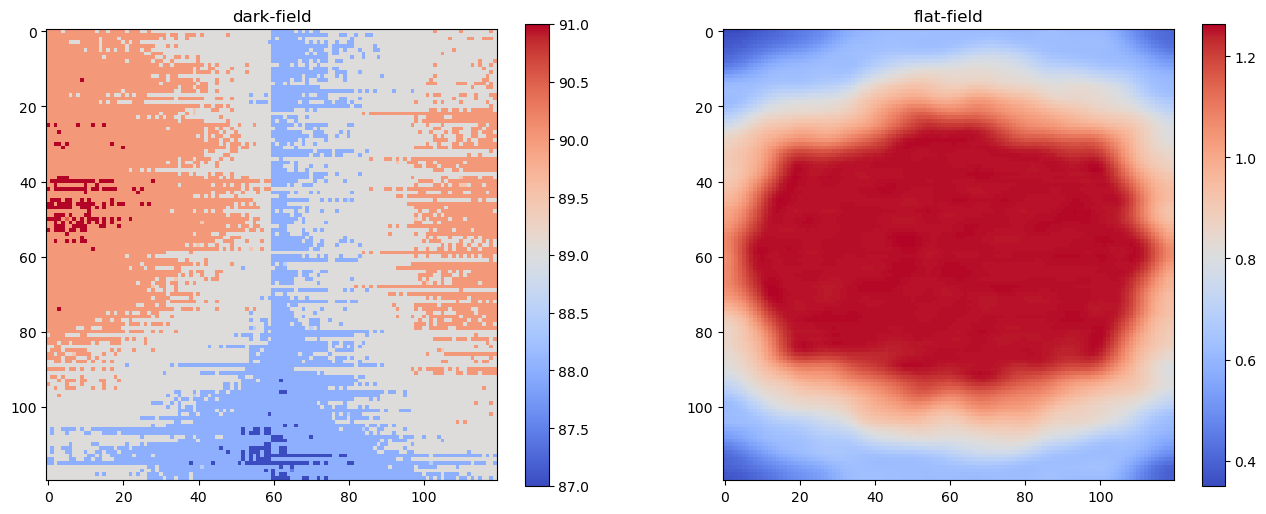

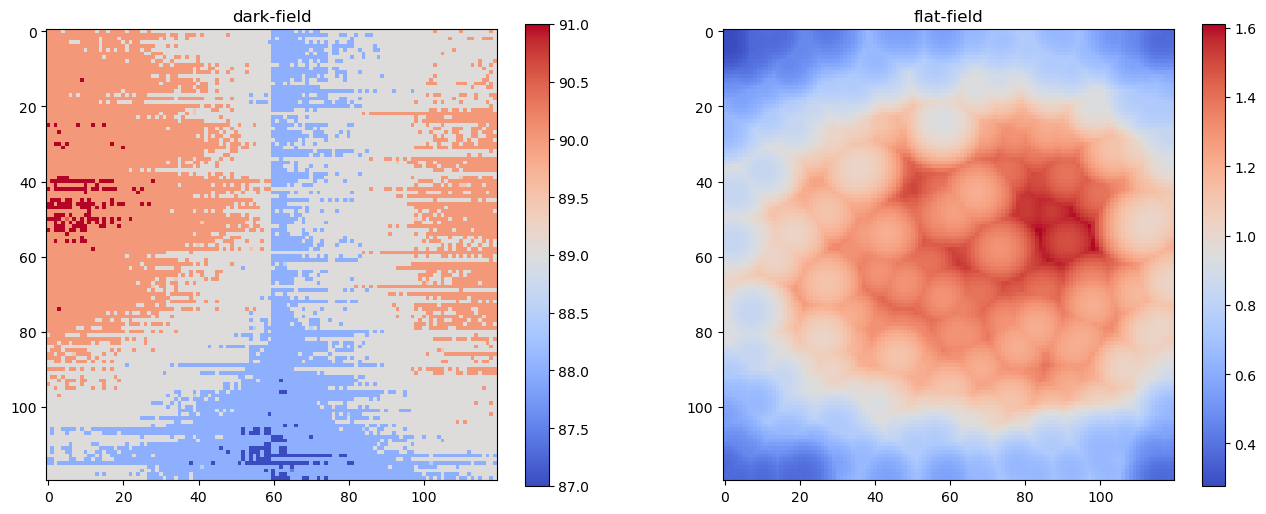

In [8]:
plot(dx1, ff1)
plot(dx2, ff2)

In [9]:
images_s1_handle  = zarr_data[f'/setup13/timepoint0/s1']
attributes = images_s1_handle.attrs.asdict()
attributes['pixelResolution'] = [0.23, 0.23, 0.42] # useful later
print(attributes)

{'downsamplingFactors': [2, 2, 1], 'pixelResolution': [0.23, 0.23, 0.42]}


In [10]:
n5_root = zarr.open_group(store=zarr.N5Store(outpath), mode='w')

In [11]:
%%time
images_s1_raw = images_s1_handle[...]

CPU times: user 27.8 s, sys: 3.45 s, total: 31.2 s
Wall time: 32.6 s


# c00

In [12]:
%%time
a = np.clip(images_s1_raw.astype(np.float16)-90, 0, None).astype(np.uint16)

CPU times: user 1min 23s, sys: 17 s, total: 1min 40s
Wall time: 1min 40s


In [13]:
%%time
dataset = n5_root.require_dataset(
    'c00/s1',
    shape=a.shape,
    chunks=(64, 128, 128),
    dtype=a.dtype,
    compressor=GZip(level=1),
    data=a)
# set additional attributes
dataset.attrs.update(**attributes)

n5_root['c00/s1']

CPU times: user 1min 5s, sys: 5.84 s, total: 1min 11s
Wall time: 1min 34s


<zarr.core.Array '/c00/s1' (2837, 960, 960) uint16>

In [14]:
!ls $outpath
!cat $outpath/attributes.json
!cat $outpath/c00/s1/attributes.json

attributes.json  c00
{
    "n5": "2.0.0"
}{
    "blockSize": [
        128,
        128,
        64
    ],
    "compression": {
        "level": 1,
        "type": "gzip",
        "useZlib": false
    },
    "dataType": "uint16",
    "dimensions": [
        960,
        960,
        2837
    ],
    "downsamplingFactors": [
        2,
        2,
        1
    ],
    "pixelResolution": [
        0.23,
        0.23,
        0.42
    ]
}

# c0_bs

In [15]:
%%time
a = transform_pipe(images_s1_raw, dx1, ff1)

CPU times: user 27.3 s, sys: 38.7 s, total: 1min 6s
Wall time: 1min 6s


In [16]:
%%time
dataset = n5_root.require_dataset(
    'c0_bs/s1',
    shape=a.shape,
    chunks=(64, 128, 128),
    dtype=a.dtype,
    compressor=GZip(level=1),
    data=a)
# set additional attributes
dataset.attrs.update(**attributes)

n5_root['c0_bs/s1']

CPU times: user 1min 7s, sys: 6.71 s, total: 1min 14s
Wall time: 1min 37s


<zarr.core.Array '/c0_bs/s1' (2837, 960, 960) uint16>

# c0_rb

In [17]:
%%time
a = transform_pipe(images_s1_raw, dx2, ff2)

CPU times: user 26.4 s, sys: 35.8 s, total: 1min 2s
Wall time: 1min 2s


In [18]:
%%time
dataset = n5_root.require_dataset(
    'c0_rb/s1',
    shape=a.shape,
    chunks=(64, 128, 128),
    dtype=a.dtype,
    compressor=GZip(level=1),
    data=a)
# set additional attributes
dataset.attrs.update(**attributes)

n5_root['c0_rb/s1']

CPU times: user 1min 4s, sys: 4.37 s, total: 1min 9s
Wall time: 1min 34s


<zarr.core.Array '/c0_rb/s1' (2837, 960, 960) uint16>